In [3]:
import pandas as pd
import numpy as np
import networkx as nx

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (7,2)
plt.rcParams['figure.dpi'] = 150

In [5]:
rng = np.random.default_rng()

## Network creation functions

In [6]:
# auxiliary functions
# define the initial condition and network
def set_network(G, initial_state=None, pos=None):
    if not initial_state:
        initial_state = rng.choice([-1,1], size=G.number_of_nodes())
    if not pos:
        pos = nx.spring_layout(G, scale=2, seed=213123)

    assert G.number_of_nodes() == len(initial_state)
    
    # generate the initial condition'
    # each node has opinion -1 or +1'
    # and ensure that nodes are indexed from 0 to N
    G = nx.convert_node_labels_to_integers(G)

    return G, initial_state, pos

In [7]:
def draw_network(G, state, pos, ax=None, node_size=50, colors=['blue', 'red']):
    nx.draw(G, pos=pos, node_color=np.where(state == 1, *colors), ax = ax, node_size=node_size)

In [8]:
def calc_giant_size(G):
    largest_cc = max(nx.connected_components(G), key=len)
    return len(largest_cc)/G.number_of_nodes()

In [9]:
def calc_number_of_active_links(G, state):
    return np.array(
        [
            sum(1 for nn in G.neighbors(n) if state[nn] != state[n])
            for n in G.nodes()
        ]
    )

In [10]:
def create_degree_induced_opinion(G, state, thr=0.95):
    state[:] = -1
    degrees = {n: G.degree(n) for n in G.nodes}
    k_hub = pd.Series(degrees.values()).quantile(thr)
    state[[n for n, k in degrees.items() if k > k_hub]] = 1
    return state, k_hub

### Dynamics functions

In [11]:
class original_dynamics:

    def __init__(self, G, state, rng, p, q):
        # probabilities
        self.p = p
        self.q = q
        self.rng = rng

        # graph
        self.G = G
        self.state = state
        self.ai = calc_number_of_active_links(G, state)

        # set of nodes with a given opinion
        self.set_nodes = {s : set(np.where(self.state == s)[0]) for s in [-1,1]}

    def get_degrees(self):
        # auxiliary
        return {n: self.G.degree(n) for n in self.G.nodes}

    def make_rewiring(self, i, j):
            # we rewire
            # delete the edge
            self.G.remove_edge(i,j)
            self.ai[i] -= 1
            self.ai[j] -= 1

            # add a new one if possible
            _set_choice = list(set(self.set_nodes[self.state[i]]) - set(self.G.neighbors(i)) - set([i]))
            if len(_set_choice) > 0:
                new_j = self.rng.choice(_set_choice)
                self.G.add_edge(i, new_j)

    def perform_change_of_opinion(self, i):
        self.set_nodes[self.state[i]].remove(i)
        self.set_nodes[-self.state[i]].add(i)

        self.state[i] = -self.state[i]

        # remove the active links of its neighbors with same state
        for nn in self.G.neighbors(i):
            if self.state[i] == self.state[nn]:
                # then, remove the active link
                self.ai[i] -= 1
                self.ai[nn] -= 1
            else:
                # add active links
                self.ai[i] += 1
                self.ai[nn] += 1

    def make_change_of_opinion(self, i, j):
        self.perform_change_of_opinion(i)

    def perform_time_step(self, rnd1, rnd2):
        # pick a random node
        i = rng.choice(range(0,self.G.number_of_nodes()))

        # calculate the number of active links of i
        if rnd1 < (self.ai[i] / self.G.degree(i))**self.q:
            # will do something
            # pick a random j
            j = self.rng.choice([nn for nn in self.G.neighbors(i) if self.state[i] != self.state[nn]])
            if rnd2 < p:
                self.make_rewiring(i, j)
            else:
                self.make_change_of_opinion(i,j)
    
    def test_if_can_stop(self, measurements=None):
        _res = False
        _reason = None
        if np.sum(self.ai) == 0:
            _res = True 
            _reason = 'No active link'

        if measurements:
            pass

        return _res, _reason

In [12]:
# define the reverse dynamics
class reverse_dynamics(original_dynamics):
    def make_change_of_opinion(self, i, j):
        self.perform_change_of_opinion(j)

In [13]:
class measurements:
    def __init__(self, dyn):
        self.dyn = dyn

        # measures
        self.rho = []
        self.avg_k = []
        self.S = []
        self.m = []

    def measure(self):
        self.rho.append(
            np.sum(self.dyn.ai) / (2.0*self.dyn.G.number_of_edges())
        )
        self.avg_k.append(
            sum([self.dyn.G.degree(n) for n in self.dyn.G.nodes]) / self.dyn.G.number_of_nodes()
        )
        self.m.append(
            abs(np.sum(self.dyn.state)) / self.dyn.G.number_of_nodes()
        )
        self.S.append(
            calc_giant_size(self.dyn.G)
        )

## Defining the network

In [14]:
pars_net = {
    'N' : 200,
    'm' : 4
}

In [15]:
ori_G, ori_current_state, ori_pos = set_network(
    nx.barabasi_albert_graph(pars_net['N'], 4)
)
#nx.grid_2d_graph(10,10,periodic=True)) #nx.complete_graph(20))

ori_current_state, k_hub = create_degree_induced_opinion(ori_G, ori_current_state)

# Create figures

Stopped! Reason: No active link


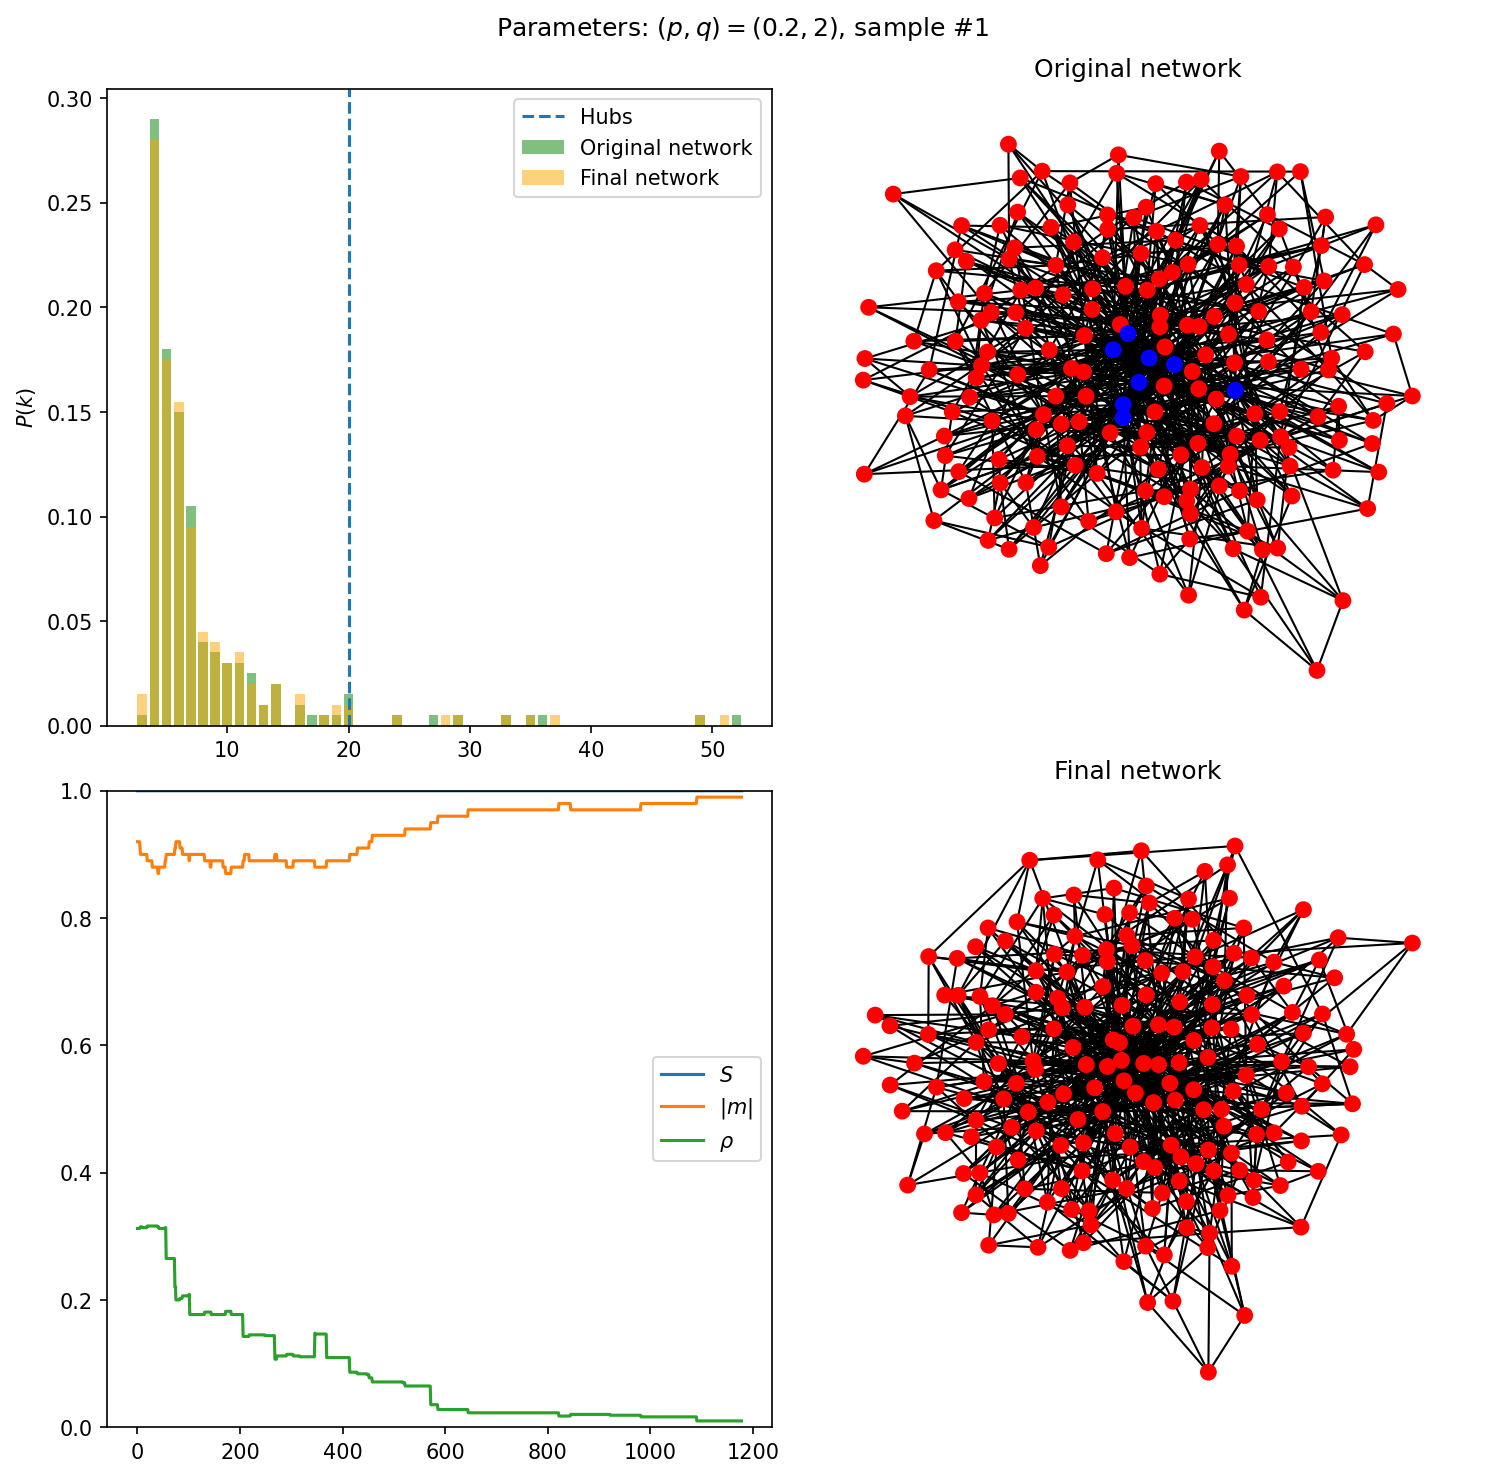

Stopped! Reason: No active link


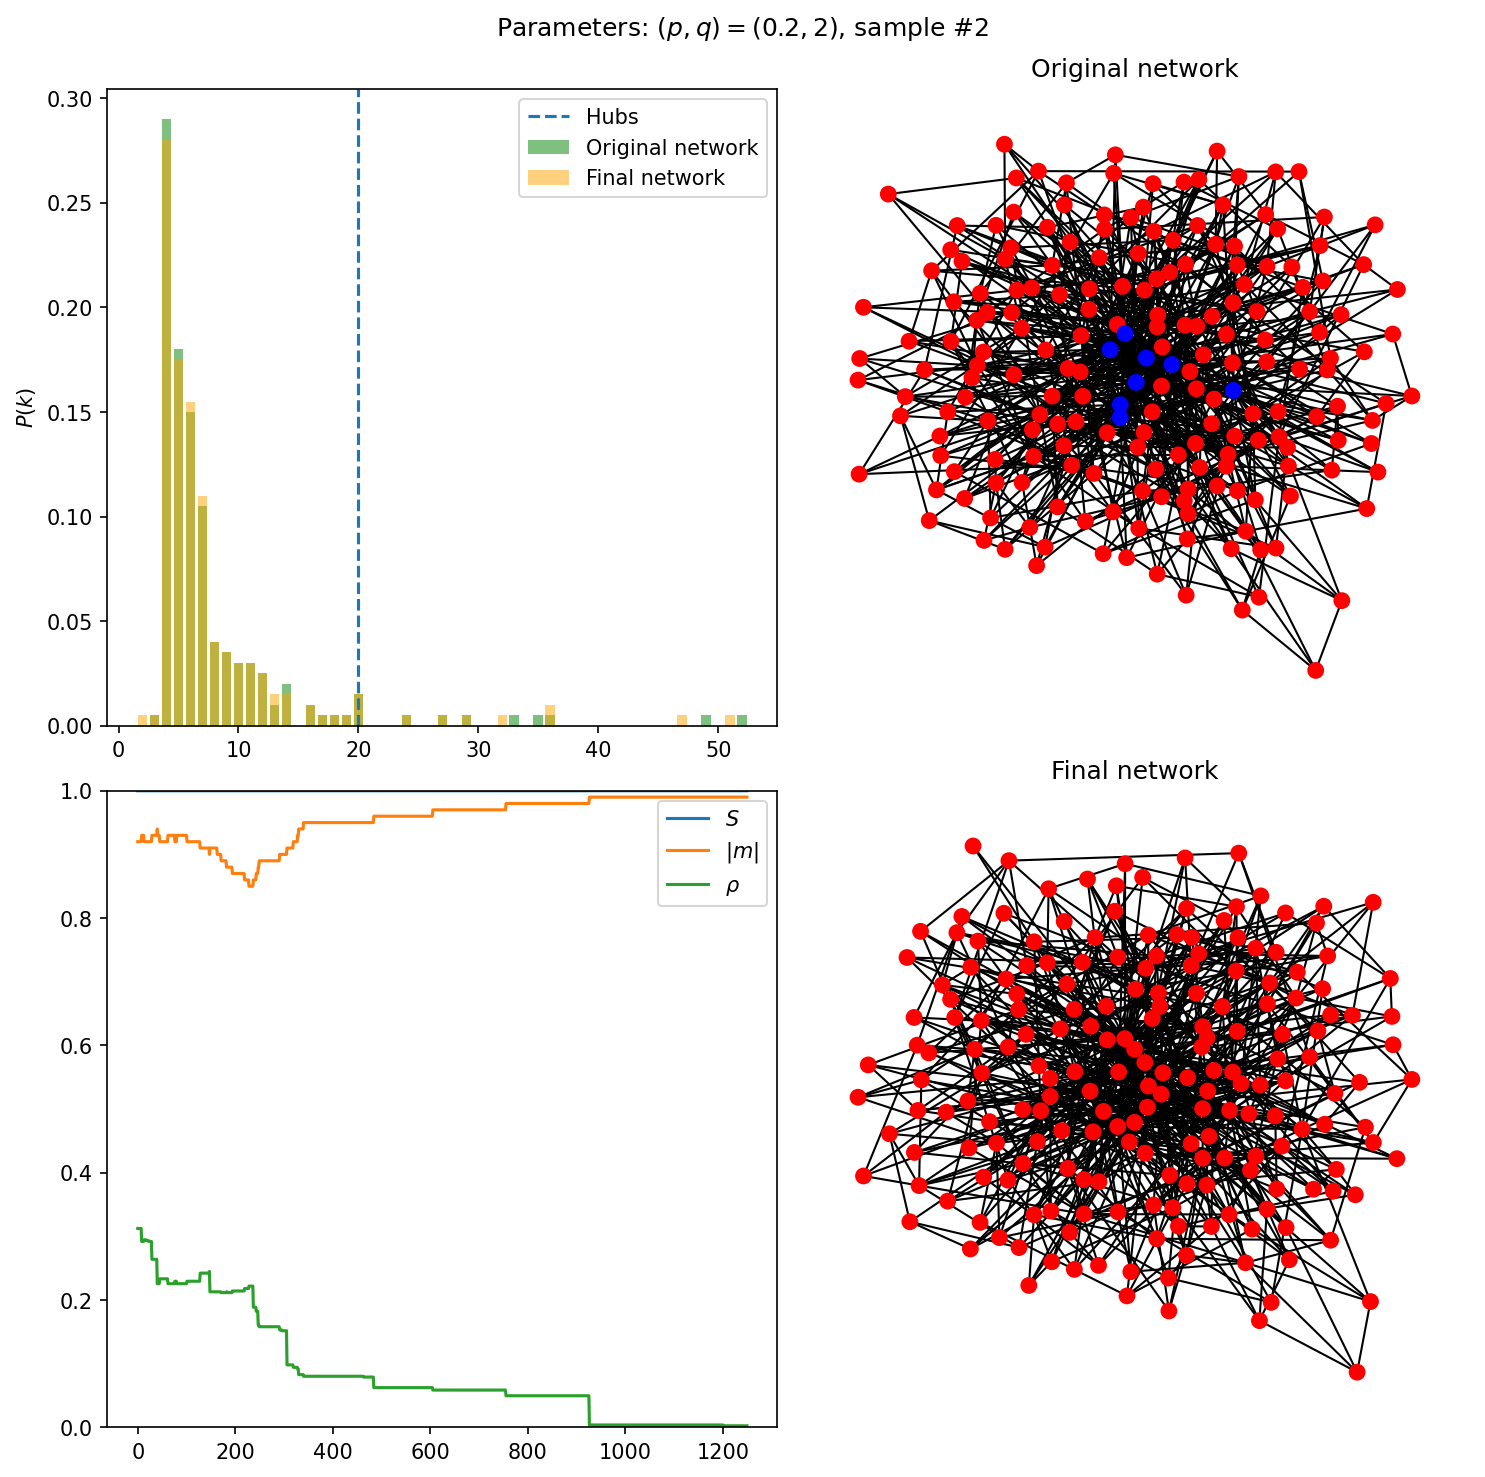

Stopped! Reason: No active link


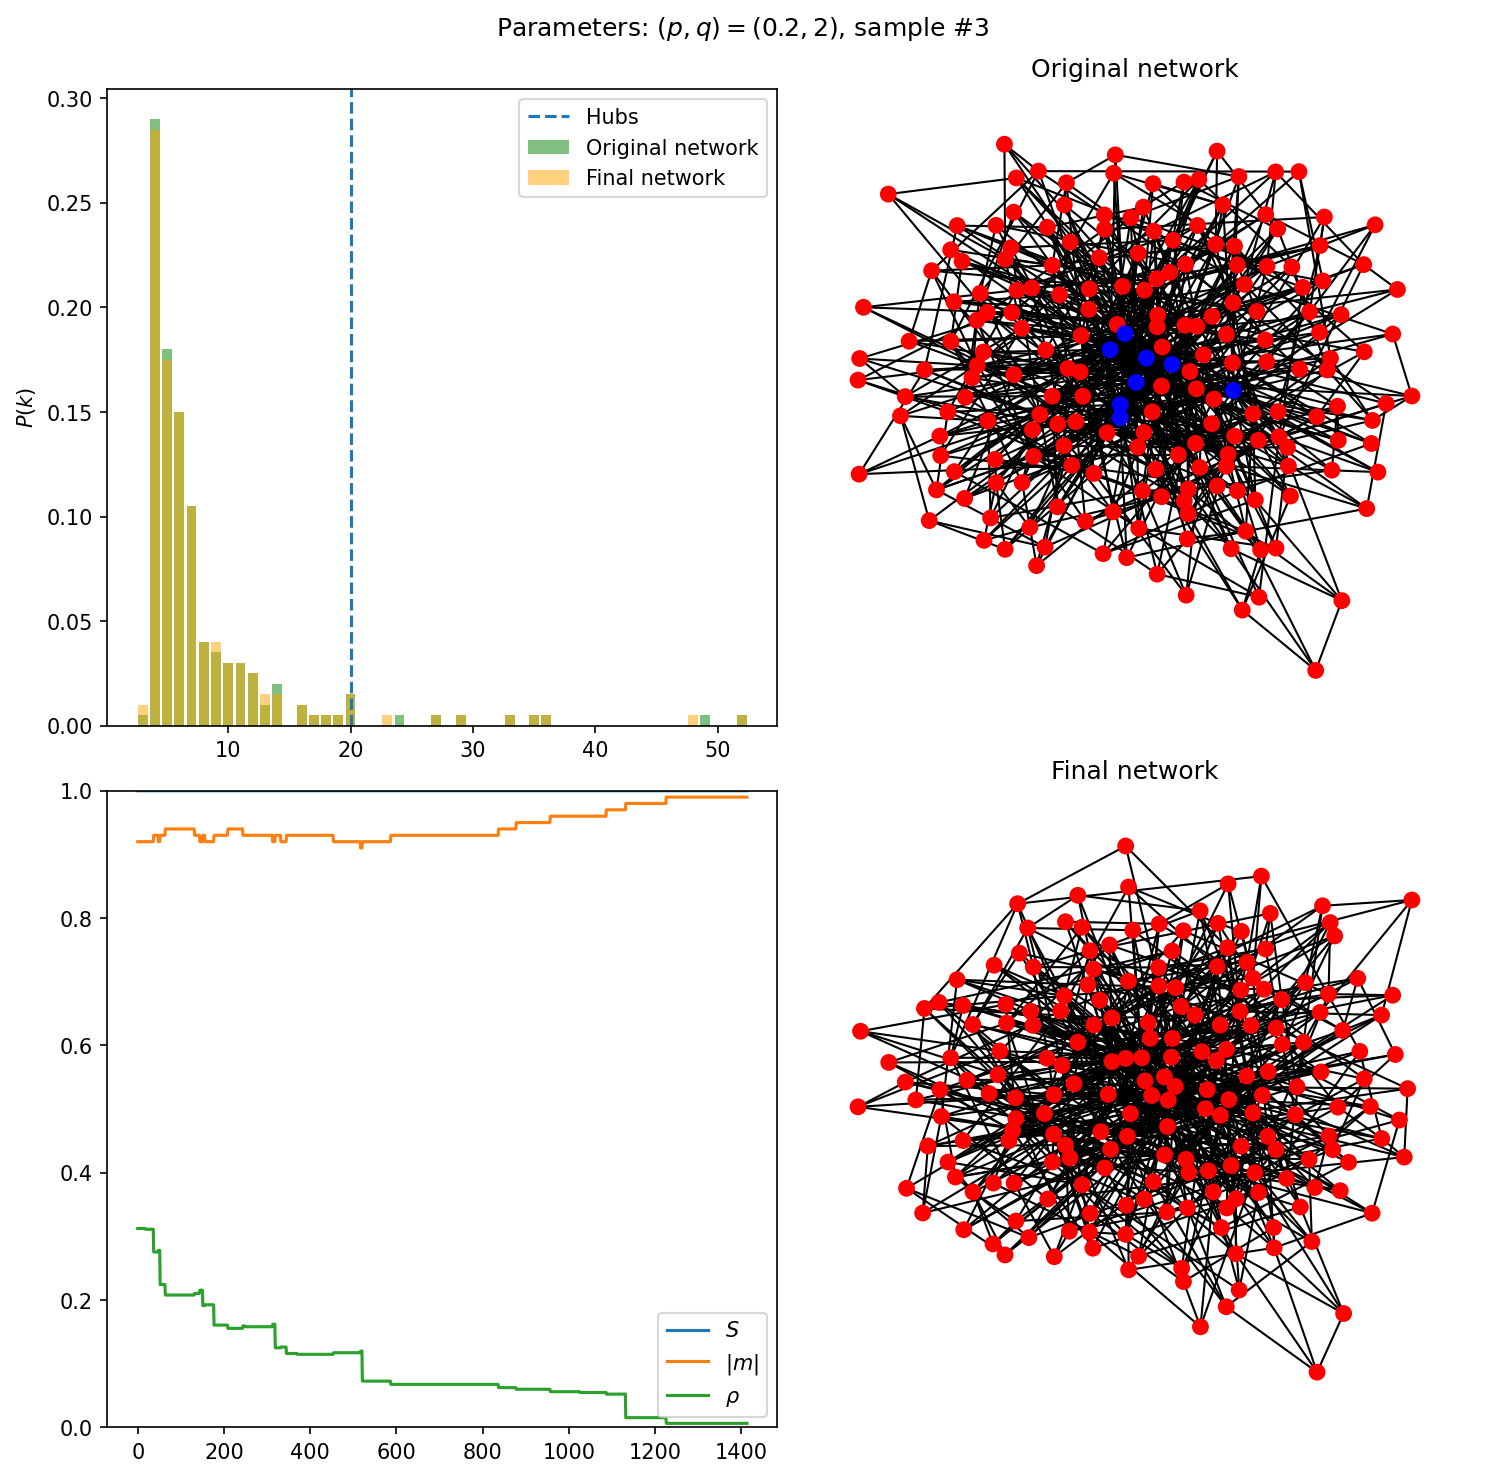

Stopped! Reason: No active link


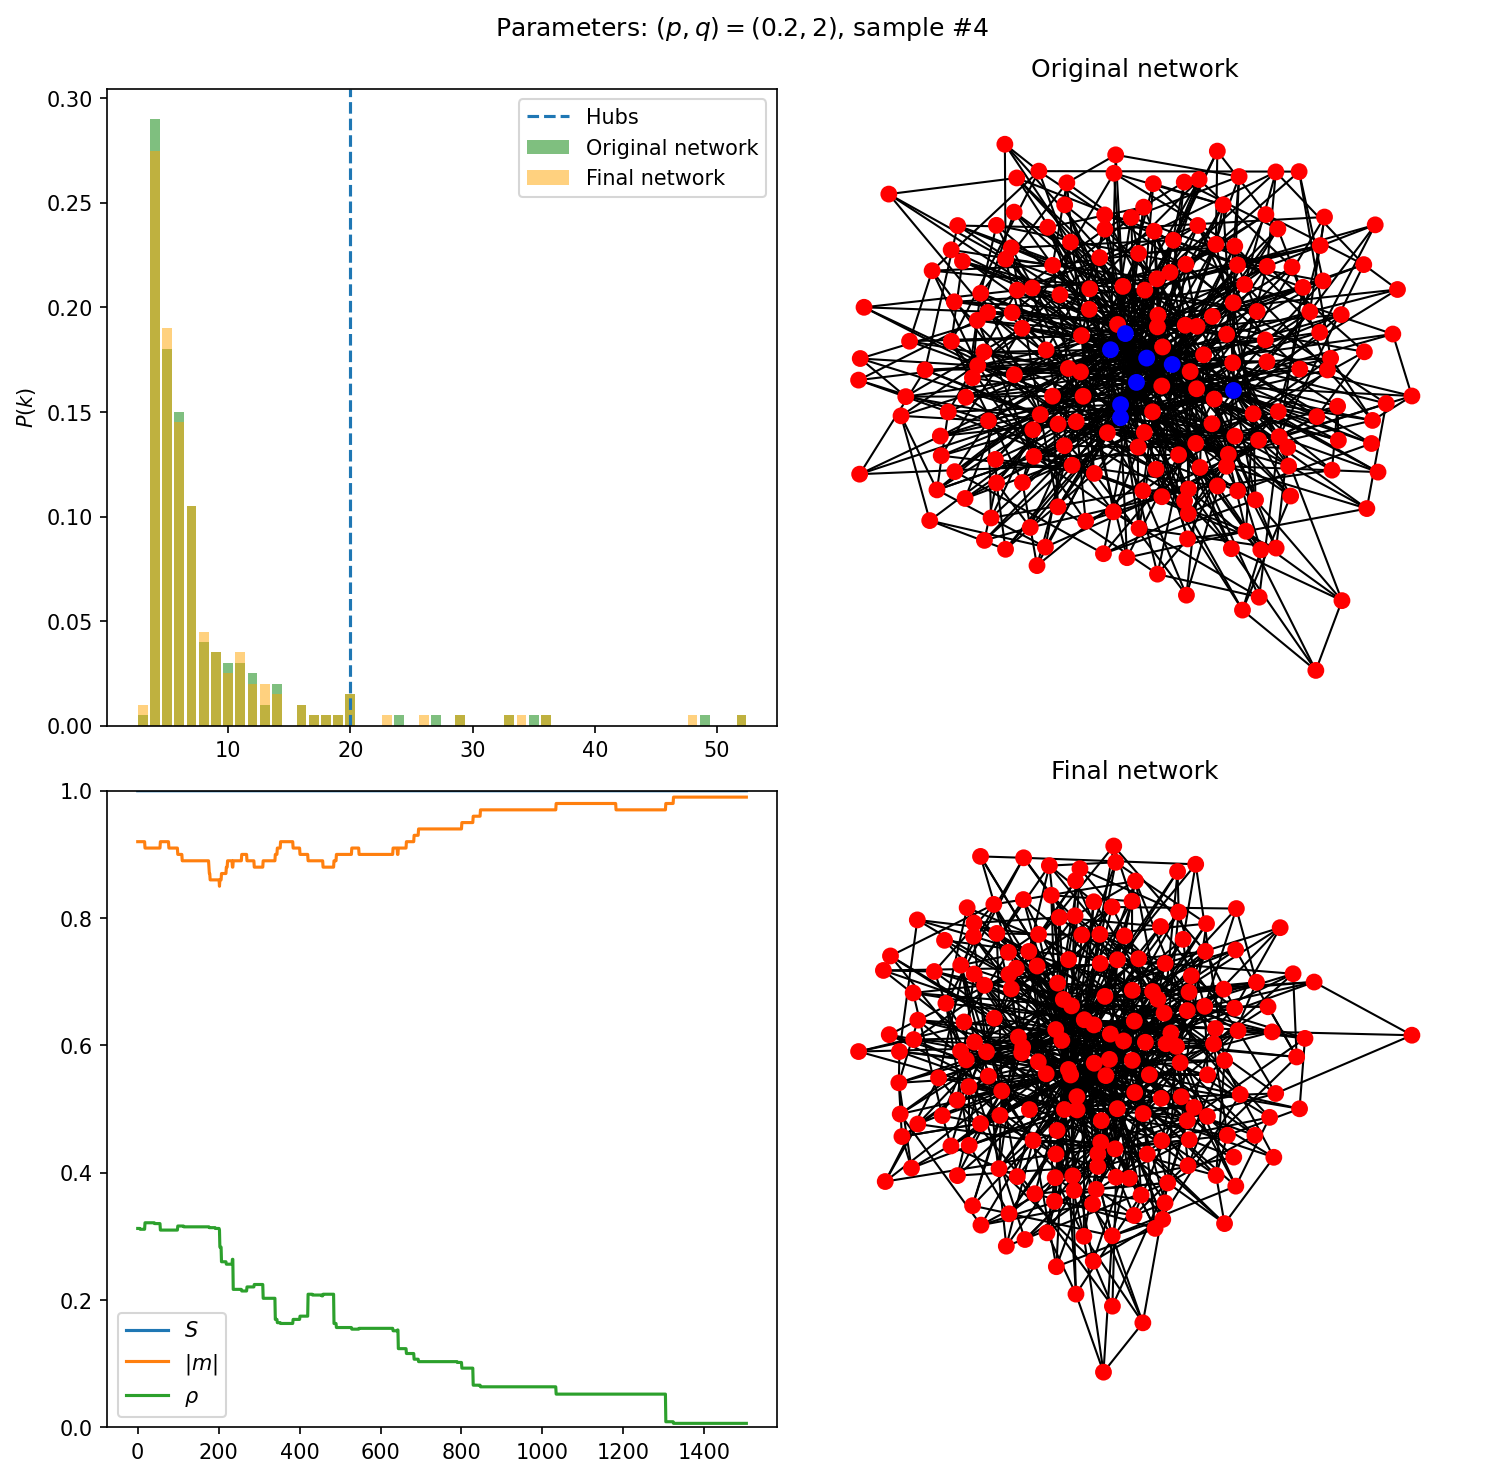

Stopped! Reason: No active link


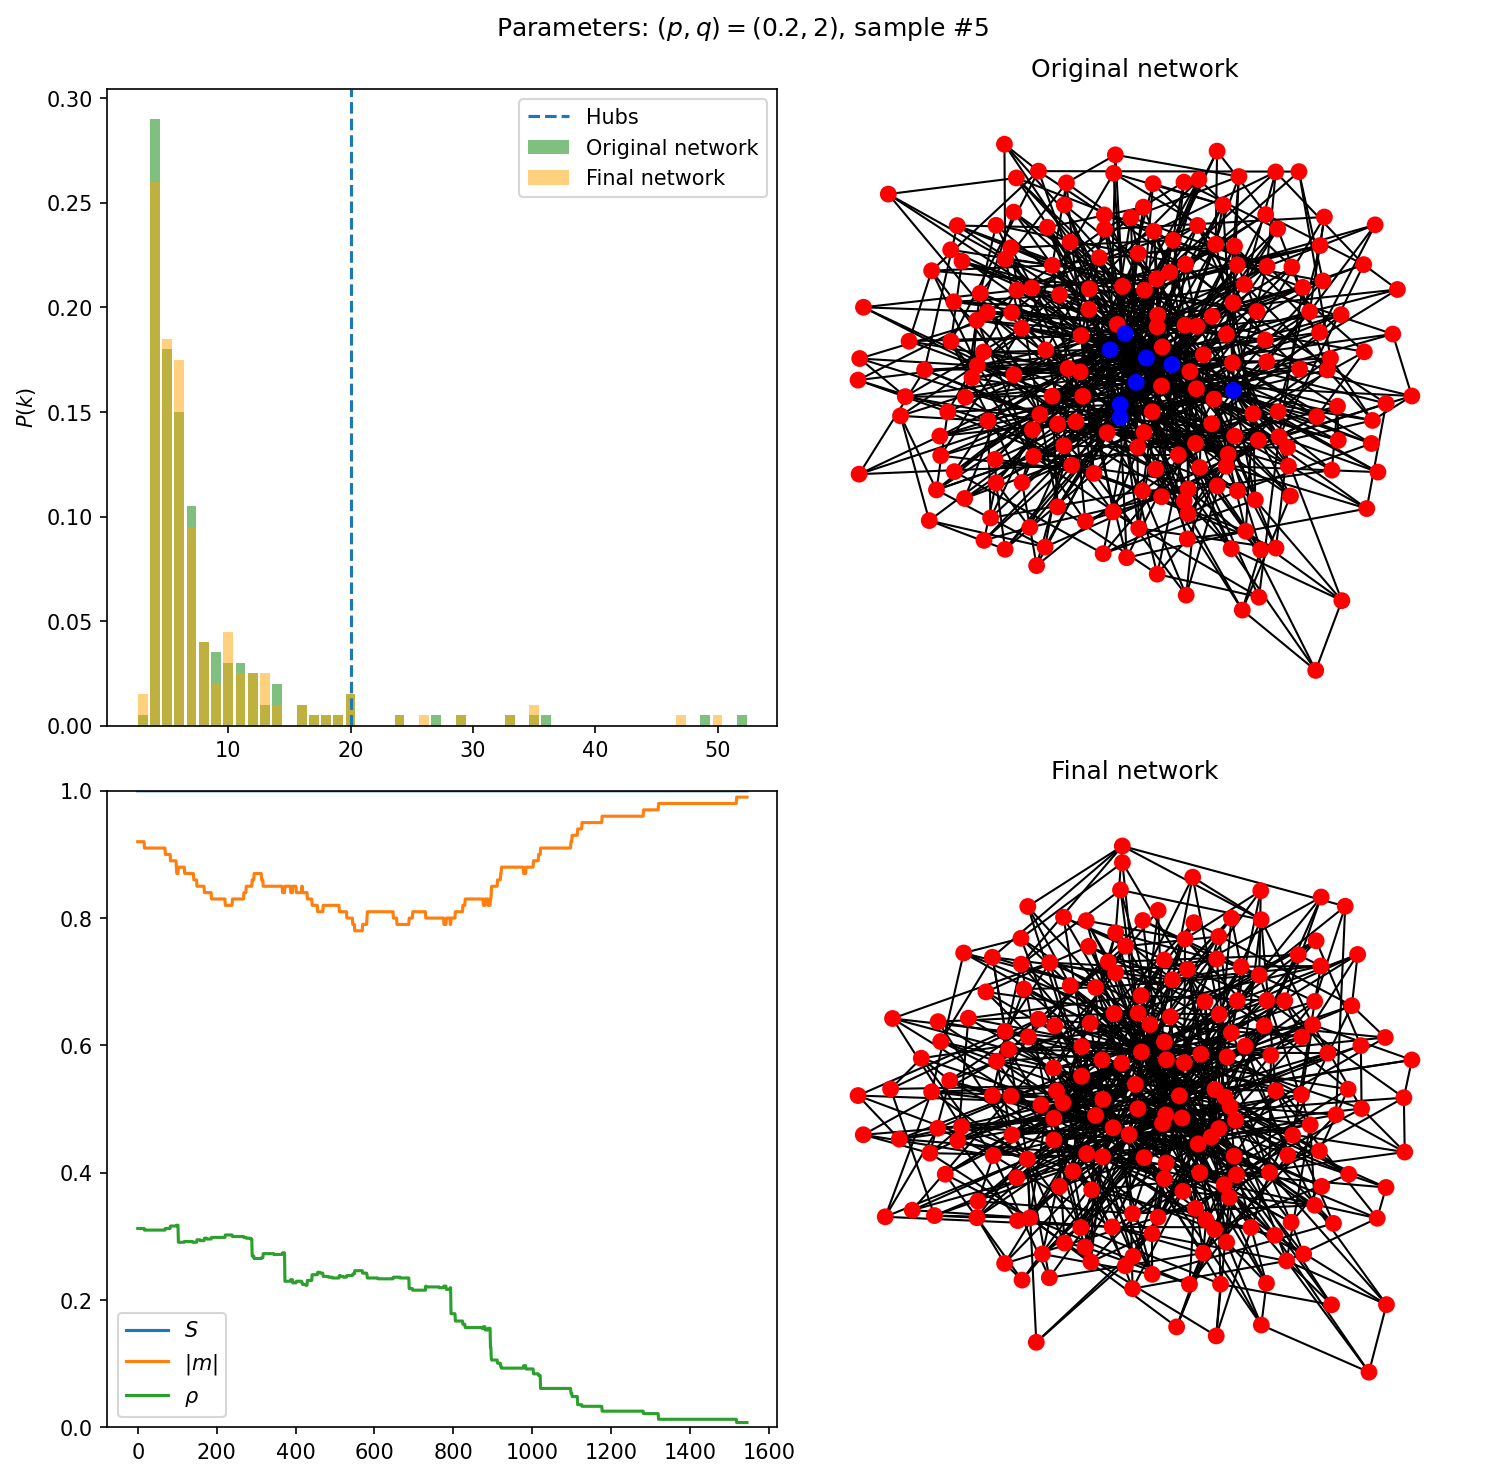

<ipython-input-11-dc465c987d49>:59: RuntimeWarning: invalid value encountered in long_scalars
  if rnd1 < (self.ai[i] / self.G.degree(i))**self.q:


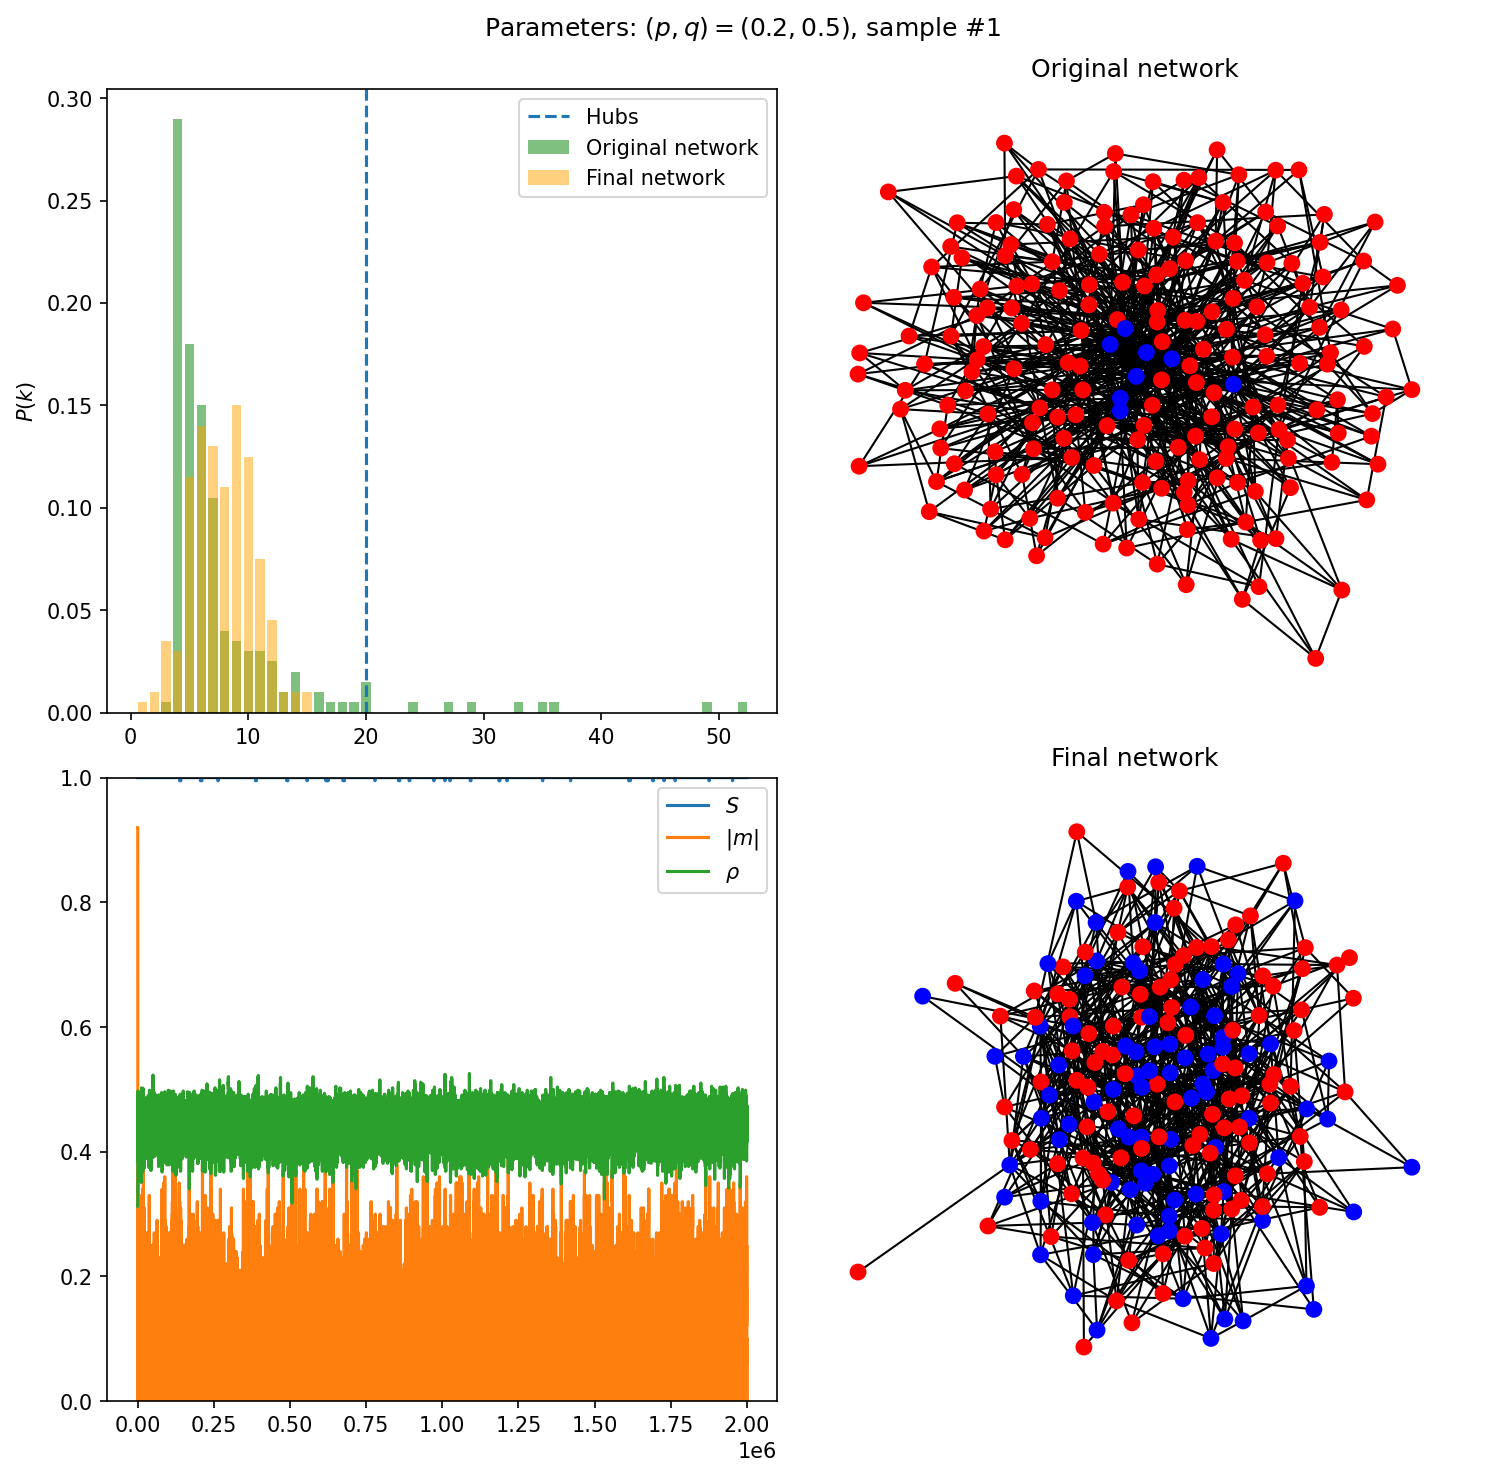

In [ ]:
for (p,q) in [(0.2,2), (0.2,0.5), (0.8,0.5)]:
    for _s in range(1,6):
        fig, axs = plt.subplots(nrows = 2, ncols=2, figsize=(10,10))
        fig.suptitle(rf'Parameters: $(p,q) = ({p}, {q})$, sample #{_s}')

        # define the dynamics
        dyn = original_dynamics(ori_G.copy(), ori_current_state.copy(), rng, p, q)
        # measurements
        measures = measurements(dyn)

        # make histogram of degrees
        degrees = dyn.get_degrees()
        _hist = {k: v / dyn.G.number_of_nodes() for k, v in pd.Series(degrees.values()).value_counts().sort_index().to_dict().items()}
        axs[0,0].bar(_hist.keys(), _hist.values(), label='Original network', color='green', alpha=0.5)
        axs[0,0].axvline(k_hub, linestyle='--', label='Hubs')

        draw_network(dyn.G, dyn.state, ori_pos.copy(), ax = axs[0,1])
        axs[0,1].set_title('Original network')

        for t, (rnd1,rnd2) in enumerate(rng.random(size=(10000*dyn.G.number_of_nodes(), 2))):
            measures.measure()
            dyn.perform_time_step(rnd1, rnd2)
            _stop_now, _stop_reason = dyn.test_if_can_stop(measures)
            if _stop_now:
                print(f'Stopped! Reason: {_stop_reason}')
                break
  
        # plot final results
        axs[0,0].set_ylabel(r'$P(k)$')
        degrees = dyn.get_degrees()
        _hist = {k: v / dyn.G.number_of_nodes() for k, v in pd.Series(degrees.values()).value_counts().sort_index().to_dict().items()}
        axs[0,0].bar(_hist.keys(), _hist.values(), label='Final network', color='orange', alpha=0.5)
        axs[0,0].legend()

        axs[1,0].plot(measures.S, label=r'$S$')
        axs[1,0].plot(measures.m, label=r'$|m|$')
        axs[1,0].plot(measures.rho, label=r'$\rho$')
        axs[1,0].set_ylim(0,1)
        axs[1,0].legend()

        draw_network(dyn.G,dyn.state,nx.spring_layout(dyn.G, scale=2, seed=213123), ax = axs[1,1])
        axs[1,1].set_title('Final network')

        fig.tight_layout()
        plt.show()
        plt.clf()
        plt.close()